# Black-Scholes Option Pricing Engine — Multi-Ticker Implementation

This notebook implements a modular engine for pricing call options using the Black-Scholes model.  
It supports multi-asset pricing, real-market volatility estimation, and includes visual diagnostics such as 3D pricing surfaces and sensitivity heatmaps.

This version is optimized for extensibility (stress testing, exotic instruments), interpretability (clear structure and plots), and fast prototyping in a quant research context.


### Formula Recap

The Black-Scholes formula for a European call option is:

\\[
C = S N(d_1) - K e^{-rT} N(d_2)
\\]

with

\\[
d_1 = \\frac{\ln(S/K) + (r + \\frac{1}{2} \\sigma^2)T}{\\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T}
\\]

where:
- \\( S \\) = current stock price  
- \\( K \\) = strike price  
- \\( T \\) = time to maturity  
- \\( r \\) = risk-free rate  
- \\( \sigma \\) = volatility  
- \\( N(x) \\) = cumulative standard normal distribution



### Black-Scholes Functions

Core pricing and greeks implementation (Delta, Gamma, Vega) for vanilla options.  
Functions are vectorized for efficient integration with surface generation and analytics tools.

**The model assumes:**
- No dividends
- Efficient markets
- Constant volatility and interest rates
- Log-normal distribution of returns
- European-style option (exercisable only at maturity)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from ipywidgets import interact, FloatSlider
import numpy as np
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def black_scholes_price(S, K, T, r, sigma, option_type):
    """
    Calculate Black-Scholes option price
    
    Parameters:
    S: Stock price
    K: Strike price
    T: Time to maturity in years
    r: Risk-free interest rate
    sigma: Volatility
    option_type: 'call' or 'put'
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price

def bs_delta(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes delta"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option_type == 'call':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1
    
    return delta

def bs_vega(S, K, T, r, sigma):
    """Calculate Black-Scholes vega"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = S * np.sqrt(T) * norm.pdf(d1) * 0.01  # Scaled by 0.01 for 1% change
    return vega

def bs_gamma(S, K, T, r, sigma):
    """Calculate Black-Scholes gamma"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma


### Data Import & Preprocessing

Historical close prices for multiple tickers are processed to compute annualized historical volatility.  
All volatility inputs are local (no API dependency) and computed via rolling windows.


In [6]:
df = pd.read_csv("stock_data_multi.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Ticker', 'Date'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Volatility'] = df.groupby('Ticker')['Return'].transform(lambda x: x.rolling(21).std() * np.sqrt(252))
df.dropna(inplace=True)
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Return,Volatility
21,2023-05-02,AAPL,101.955214,104.258863,99.356831,101.744743,3468010,-0.013817,0.275927
22,2023-05-03,AAPL,100.274321,97.401986,101.112680,100.438884,1679892,-0.012835,0.266783
23,2023-05-04,AAPL,97.621922,101.450181,98.133078,98.962476,2701591,-0.014700,0.247183
24,2023-05-05,AAPL,101.331827,100.212780,97.434987,100.418827,2984681,0.014716,0.250110
25,2023-05-08,AAPL,99.796783,101.942921,97.161045,99.492657,2636091,-0.009223,0.252374



### Multi-Ticker Pricing Snapshot

Prices and greeks computed for each ticker using the most recent spot and rolling volatility.  
Useful for building a cross-asset dashboard or feeding into downstream hedging logic.


In [7]:
def generate_summary(ticker_list, df, T=0.5, r=0.03, moneyness=1.0):
    results = []
    for ticker in ticker_list:
        data = df[df['Ticker'] == ticker]
        if data.empty:
            continue
        S = data['Close'].iloc[-1]
        K = S * moneyness
        sigma = data['Volatility'].iloc[-1]
        call = black_scholes_price(S, K, T, r, sigma, 'call')
        put = black_scholes_price(S, K, T, r, sigma, 'put')
        delta = bs_delta(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        gamma = bs_gamma(S, K, T, r, sigma)
        results.append({
            'Ticker': ticker, 'Spot': round(S, 2), 'Strike': round(K, 2),
            'Vol (%)': round(sigma * 100, 2), 'Call Price': round(call, 2),
            'Put Price': round(put, 2), 'Delta': round(delta, 3),
            'Vega': round(vega, 3), 'Gamma': round(gamma, 3)
        })
    return pd.DataFrame(results)


summary_df = generate_summary(df['Ticker'].unique(), df)
summary_df

,Ticker,Spot,Strike,Vol (%),Call Price,Put Price,Delta,Vega,Gamma
0,AAPL,79.81,79.81,24.41,6.06,4.88,0.569,0.222,0.029
1,MSFT,98.10,98.10,26.42,8.00,6.54,0.569,0.273,0.021
2,NVDA,67.42,67.42,32.92,6.72,5.71,0.572,0.187,0.025
3,TSLA,101.58,101.58,24.74,7.81,6.30,0.569,0.282,0.022



### Interactive Pricing Interface (Widget-Based)

Allows dynamic scenario testing: change strike and vol inputs to observe price and delta impacts per ticker.  
Designed to simulate how options desks stress test PnL across simple dimensions.


In [8]:
@interact(
    volatility=FloatSlider(min=0.05, max=0.6, step=0.01, value=0.2, description='Volatility'),
    strike_mult=FloatSlider(min=0.8, max=1.2, step=0.01, value=1.0, description='Strike %'),
)
def option_simulator(volatility, strike_mult):
    for ticker in df['Ticker'].unique():
        data = df[df['Ticker'] == ticker]
        S = data['Close'].iloc[-1]
        K = S * strike_mult
        call = black_scholes_price(S, K, 0.5, 0.03, volatility, 'call')
        delta = bs_delta(S, K, 0.5, 0.03, volatility)
        print(f"{ticker}: Call = {call:.2f}, Delta = {delta:.3f}")

interactive(children=(FloatSlider(value=0.2, description='Volatility', max=0.6, min=0.05, step=0.01), FloatSli…

### Black-Scholes Model: Visualization & Greeks

Focus on visualizing the pricing surface and key Greeks such as Delta and Vega.


In [7]:
# Black-Scholes pricing and Greeks
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2.) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2.) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2.) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)


In [8]:
# Parameters
K = 100
r = 0.05
sigma = 0.2
S_vals = np.linspace(50, 150, 100)
T_vals = np.linspace(0.01, 2, 100)
S, T = np.meshgrid(S_vals, T_vals)

In [9]:
# Compute Black-Scholes metrics
C = bs_call_price(S, K, T, r, sigma)
Delta = bs_delta(S, K, T, r, sigma)
Vega = bs_vega(S, K, T, r, sigma)

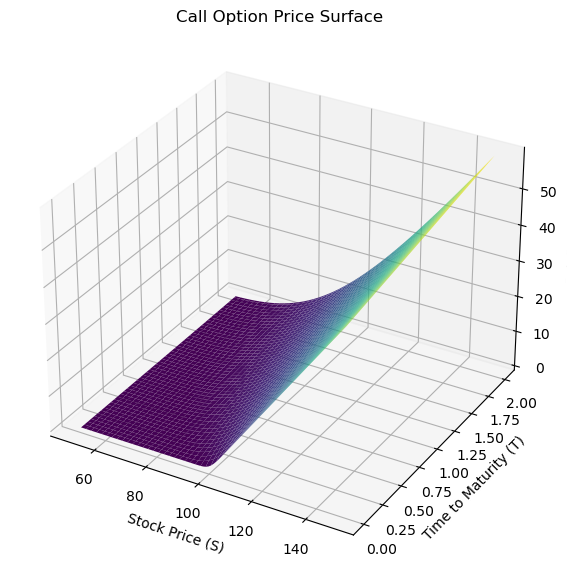

In [10]:
# Plot Call Option Price Surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, T, C, cmap='viridis')
ax.set_title('Call Option Price Surface')
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Call Price')
plt.show()


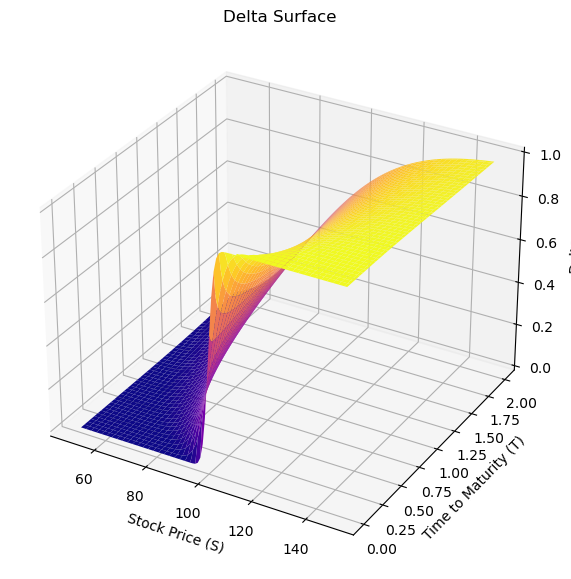

In [11]:
# Plot Delta Surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, T, Delta, cmap='plasma')
ax.set_title('Delta Surface')
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Delta')
plt.show()

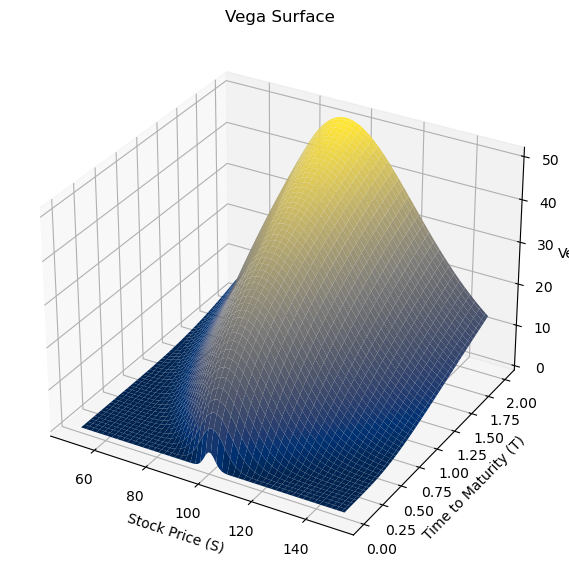

In [12]:
# Plot Vega Surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, T, Vega, cmap='cividis')
ax.set_title('Vega Surface')
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Vega')
plt.show()

### Delta Surface — Volatility vs Moneyness

This surface captures how Delta evolves with respect to implied volatility and relative strike (K/S).  
This view is particularly relevant for structuring, delta-hedging, and volatility surface modeling.

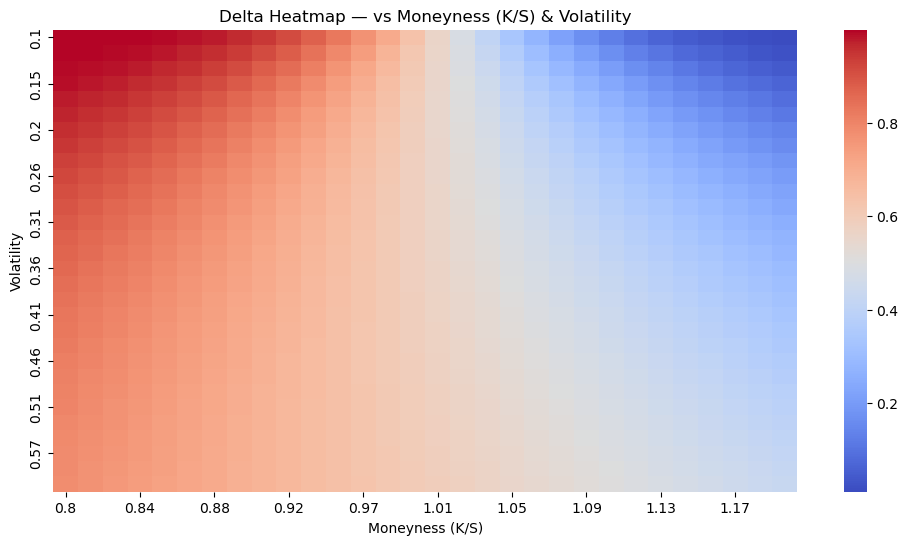

In [6]:
moneyness = np.linspace(0.8, 1.2, 30)
vols = np.linspace(0.1, 0.6, 30)
delta_map = []

S = 100
T = 0.5
r = 0.03

for sigma in vols:
    row = []
    for m in moneyness:
        K = S * m
        delta_val = bs_delta(S, K, T, r, sigma)
        row.append(delta_val)
    delta_map.append(row)

df_delta = pd.DataFrame(delta_map, index=np.round(vols, 2), columns=np.round(moneyness, 2))

plt.figure(figsize=(12, 6))
sns.heatmap(df_delta, cmap="coolwarm", xticklabels=3, yticklabels=3)
plt.title("Delta Heatmap — vs Moneyness (K/S) & Volatility")
plt.xlabel("Moneyness (K/S)")
plt.ylabel("Volatility")
plt.show()

## Summary

This module offers a compact, extensible framework for Black-Scholes pricing and surface generation.  
It’s tailored for quant interviews, desk tests, or research workflows — not a teaching tool.

Next extensions:
- Calibration to market IV surfaces  
- Monte Carlo stress testing  
- Exotic payoff logic (barrier, digital, etc.)
